# Final Project: Online Retail Data Anaysis
Description: This project is to analyse the Transaction Level Retail Data for the customers and recommend additional products for the customers
    
    
Author: Rajesh Kumar
Date: 12/16/2017

# Basic Data Loading


In [1]:
# NumPy for numerical computing
import numpy as np #linear algebra
# Pandas for DataFrames
import pandas as pd #data processing
# Matplotlib for visualization
import matplotlib.pyplot as plt
# Seaborn for easier visualization
import seaborn as sns

#sklearn to do item-item clusterring 
from sklearn import metrics
from sklearn.cluster import KMeans

In [2]:
##
# Read the CSV File
##

data = pd.read_csv('onlineretaildatasmall.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95604 entries, 0 to 95603
Data columns (total 8 columns):
InvoiceNo      95604 non-null object
StockCode      95604 non-null object
Description    95308 non-null object
Quantity       95604 non-null int64
InvoiceDate    95604 non-null object
UnitPrice      95604 non-null float64
CustomerID     61961 non-null float64
Country        95604 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 5.8+ MB


In [3]:
##
# Data Needs Cleanup
##

#data1 = data.loc[data['CustomerID'] != np.NaN & data['Quantity'].astype('int64') > 0 & data['StockCode'].astype(str).str.isdigit()]

# Cleanup data where there is no customer id associated
data1 = data.loc[data['CustomerID'] != np.NaN]

# Cleanup data where country is not UK
data1 = data1.loc[data1.Country != 'United Kingdom']

# Cleanup data where quantity is negative for returns
data1 = data1.loc[data1.Quantity > 0]

# Cleanup data where Item is POST invalid
data1 = data1.loc[data1.StockCode != 'POST']
#data1 = data1.loc[data1.CustomerID.dropna()]

# Compute the total value for each item in each transactions
data1["ItemPrice"] = data1["UnitPrice"] * data1["Quantity"]

# Drop unneccessary columns from the data
data1 = data1.drop(columns=["Description", "Country", "InvoiceDate", "InvoiceNo", "UnitPrice", "Quantity"])



#data1 = data1.loc(data1.StockCode.str.isdigit())
data1.info()


# Dump clean data to excel for a quick checkup
data1.to_csv("onlinedatatestdump.csv")
data1.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6806 entries, 26 to 94823
Data columns (total 3 columns):
StockCode     6806 non-null object
CustomerID    6655 non-null float64
ItemPrice     6806 non-null float64
dtypes: float64(2), object(1)
memory usage: 212.7+ KB


,StockCode,CustomerID,ItemPrice
26,22728,12583.0,90.0
27,22727,12583.0,90.0
28,22726,12583.0,45.0


In [4]:
## 
# Find top n items as our analysis needs to focus only on these 
##

data1['StockCode'].agg(['count'])

# Group by Items and count the total times these appear in data1 dataframe
topitems = data1.groupby(['StockCode']).size().reset_index(name='counts')

#save saved soted values
topitems = topitems.sort_values(['counts'], ascending=[False])

# Values dumps a NP array
topitems = topitems['StockCode'].head(10).values
topitems

array(['22423', '22326', '22554', '21731', '22720', '22556', '22551',
       '22629', '22961', '20750'], dtype=object)

In [5]:
## Reduce dataframe to only have top n items
data1 = data1.loc[data1.StockCode.isin(topitems)]
data1.info()
data1.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 397 entries, 34 to 94619
Data columns (total 3 columns):
StockCode     397 non-null object
CustomerID    390 non-null float64
ItemPrice     397 non-null float64
dtypes: float64(2), object(1)
memory usage: 12.4+ KB


,StockCode,CustomerID,ItemPrice
34,22326,12583.0,70.8
35,22629,12583.0,46.8
39,21731,12583.0,39.6
1240,22556,12433.0,39.6
1242,22554,12433.0,39.6


In [6]:
## Group by Customers and Items for Total price spent by customer
aggregatedf = []
aggregatedf = data1.groupby(['CustomerID', 'StockCode']).agg(['sum'])
aggregatedf.reset_index('CustomerID')
aggregatedf.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 291 entries, (12347.0, 21731) to (17404.0, 22720)
Data columns (total 1 columns):
(ItemPrice, sum)    291 non-null float64
dtypes: float64(1)
memory usage: 3.8+ KB


In [7]:
aggregatedf.head(10)

ItemPrice
                           sum
CustomerID StockCode          
12347.0    21731         39.60
           22423         38.25
12350.0    22551         19.80
12352.0    22423         38.25
12356.0    22423        175.20
12359.0    22423         76.50
           22556         19.80
           22720         14.85
           22961         17.40
12362.0    22551         19.80

In [8]:
dataunstack = aggregatedf.unstack()
dataunstack.to_csv('UnstackedData2.csv')
#dataunstack.info()
dataunstack.head(10)

#dataunstack = aggregatedf.reset_index().pivot(columns='StockCode', index='CustomerID', values='ItemPrices')

ItemPrice                                                         
                 sum                                                         
StockCode      20750 21731 22326   22423 22551 22554 22556 22629  22720 22961
CustomerID                                                                   
12347.0          NaN  39.6   NaN   38.25   NaN   NaN   NaN   NaN    NaN   NaN
12350.0          NaN   NaN   NaN     NaN  19.8   NaN   NaN   NaN    NaN   NaN
12352.0          NaN   NaN   NaN   38.25   NaN   NaN   NaN   NaN    NaN   NaN
12356.0          NaN   NaN   NaN  175.20   NaN   NaN   NaN   NaN    NaN   NaN
12359.0          NaN   NaN   NaN   76.50   NaN   NaN  19.8   NaN  14.85  17.4
12362.0          NaN   NaN   NaN     NaN  19.8  19.8   NaN  23.4    NaN   NaN
12372.0         47.7   NaN  35.4     NaN   NaN   NaN  19.8  23.4    NaN   NaN
12373.0          NaN   NaN  35.4     NaN   NaN   NaN   NaN   NaN    NaN   NaN
12377.0         15.9   NaN  17.7     NaN  19.8   NaN  19.8  23.4    NaN   NaN
12383.0          NaN   NaN   NaN     NaN  19.8  19.8  19.8  23.4    NaN   NaN

In [15]:
#remove Nan
dataready = dataunstack.fillna(0)
dataready.head(3)

ItemPrice                                                       
                 sum                                                       
StockCode      20750 21731 22326  22423 22551 22554 22556 22629 22720 22961
CustomerID                                                                 
12347.0          0.0  39.6   0.0  38.25   0.0   0.0   0.0   0.0   0.0   0.0
12350.0          0.0   0.0   0.0   0.00  19.8   0.0   0.0   0.0   0.0   0.0
12352.0          0.0   0.0   0.0  38.25   0.0   0.0   0.0   0.0   0.0   0.0

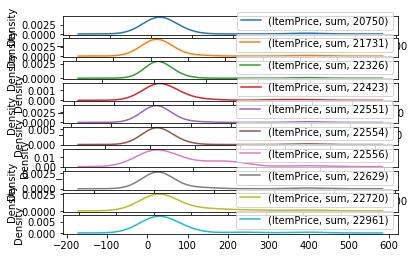

In [10]:
#data1.StockCode.unique()
dataunstack.plot(kind="density", subplots=True, sharex=False)
plt.show()

In [24]:
from sklearn.cross_validation import train_test_split


sample_df_train, sample_df_test = train_test_split(dataready, train_size=0.8)

#print sample_df_test
cluster = sklearn.cluster.KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1)
cluster.fit(sample_df_train)
result = cluster.predict(sample_df_test)
print result.size
result



21


array([3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 5, 2, 2, 2, 2, 2, 2])

In [26]:
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq

# data generation
#data = vstack((rand(150,2) + array([.5,.5]),rand(150,2)))

# computing K-Means with K = 2 (2 clusters)
centroids,_ = kmeans(dataready,10)
# assign each sample to a cluster
idx,_ = vq(dataready,centroids)

# some plotting using numpy's logical indexing
plot(dataready[idx==0,0],dataready[idx==0,1],'ob',
     dataready[idx==1,0],dataready[idx==1,1],'or')
plot(centroids[:,0],centroids[:,1],'sg',markersize=8)
show()

TypeError: unhashable type: 'numpy.ndarray'

In [22]:
import numpy as np
import matplotlib.pyplot as plt

N = 10
#data = np.random.random((N, 4))
labels = ['point{0}'.format(i) for i in range(N)]

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    dataready[:, 0], dataready[:, 1], marker='o', c=dataready[:, 2], s=dataready[:, 3] * 1500,
    cmap=plt.get_cmap('Spectral'))

for label, x, y in zip(labels, dataready[:, 0], dataready[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()

TypeError: unhashable type

In [21]:
import matplotlib.pyplot as plt
from matplotlib import mlab
import Pycluster as pc

# make fake user data
users = np.random.normal(0, 10, (20, 5))

# cluster
clusterid, error, nfound = pc.kcluster(dataready, nclusters=8, transpose=0, 
                                       npass=10, method='a', dist='e')
centroids, _ = pc.clustercentroids(dataready, clusterid=clusterid)

# reduce dimensionality
users_pca = mlab.PCA(dataready)
cutoff = users_pca.fracs[1]
users_2d = users_pca.project(dataready, minfrac=cutoff)
centroids_2d = users_pca.project(centroids, minfrac=cutoff)

# make a plot
colors = ['red', 'green', 'blue']
plt.figure()
plt.xlim([users_2d[:,0].min() - .5, users_2d[:,0].max() + .5])
plt.ylim([users_2d[:,1].min() - .5, users_2d[:,1].max() + .5])
plt.xticks([], []); plt.yticks([], []) # numbers aren't meaningful

# show the centroids
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], marker='o', c=colors, s=100)

# show user numbers, colored by their cluster id
for i, ((x,y), kls) in enumerate(zip(users_2d, clusterid)):
    plt.annotate(str(i), xy=(x,y), xytext=(0,0), textcoords='offset points',
                 color=colors[kls])

ImportError: No module named Pycluster

# Train and Test split

# Cluster Analysis